## Frequency matched case control data

https://cran.r-project.org/web/packages/ccoptimalmatch/vignettes/ccoptimalmatching_vignette.html

In [1]:
library(ccoptimalmatch)

/home/dmc2245/miniconda3/lib/python3.8/site-packages/sos_notebook/kernel.py:1334: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  msg['msg_id'] = self._parent_header['header']['msg_id']


In [2]:
## Load my raw data for f3393
raw_f3393 <- read.table ('~/UKBiobank/phenotype_files/hearing_impairment/090321_UKBB_Hearing_aid_f3393_expandedwhite_6436cases_96601ctrl_PC1_2.tsv', header=T)

In [3]:
head(raw_f3393)

,FID,IID,sex,f3393,age,PC1,PC2
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1000078,1000078,1,0,60,0.0070245643,0.009614509
2,1000081,1000081,0,0,67,-0.1198316925,-0.012082002
3,1000224,1000224,1,0,58,0.0022356173,-0.012769062
4,1000236,1000236,0,0,70,-0.0029660149,0.016806466
5,1000255,1000255,1,0,61,0.0042133323,0.002938649
6,1000291,1000291,0,0,62,0.0003901785,0.001768452


In [4]:
# Gert the number of cases and controls
table(raw_f3393$f3393)


    0     1 
96601  6436 

# Step 1: Exact Matching on several variables

In [5]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
create_subset <- raw_f3393 %>% 
                 filter(f3393 =="1") %>%
                 arrange(sex, age) %>%
                 distinct(sex, age, .keep_all = TRUE) %>%
                 mutate(subset = 1:n()) %>%
                 select(sex, age, subset)

In [7]:
create_subset

sex,age,subset
<int>,<int>,<int>
0,40,1
0,41,2
0,42,3
0,43,4
0,44,5
0,45,6
0,46,7
0,47,8
0,48,9


Merge the data that contains the subset with the cases only 

In [8]:
case_with_subset <- raw_f3393 %>% 
                          filter(f3393 =="1") %>%
                           full_join(create_subset, by = c("sex", "age"))

Merge the data that contains the subset with the controls only

In [9]:
#There's one control with age=83 which creates NA in the data since there are not cases with that age, therefore we remove it
control_with_subset <- raw_f3393 %>% 
                             filter(f3393 =="0") %>%
                             right_join(create_subset, by = c("sex", "age")) %>%
                             na.exclude()

Merge the data from cases and controls

In [10]:
not_processed <- rbind(case_with_subset,control_with_subset)

In [11]:
head(not_processed)

,FID,IID,sex,f3393,age,PC1,PC2,subset
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
1,1001384,1001384,1,1,61,0.0027161810,0.00165980,65
2,1002548,1002548,0,1,62,0.0008948446,0.01342160,23
3,1002888,1002888,0,1,68,0.0080358312,-0.00139989,29
4,1002944,1002944,0,1,65,0.0065072331,-0.01052309,26
5,1003258,1003258,0,1,74,0.0125914159,-0.01414233,35
6,1004843,1004843,0,1,64,0.0180530254,-0.04619064,25


In [12]:
# All the cases were matched to controls
table(not_processed$f3393)


    0     1 
96599  6436 

# Step 2. Create artificial observations and select the range of variables

In [13]:
bdd_controls <- not_processed[not_processed$f3393=="0",]
bdd_controls$cluster_case <- 0

In [14]:
bdd_cases <- not_processed[not_processed$f3393=="1",]
bdd_cases$cluster_case <- paste("1",1:nrow(bdd_cases),sep = "_")

In [15]:
not_processed <- rbind(bdd_cases,bdd_controls)

In [16]:
bdd_cases <- not_processed[not_processed$f3393=="1",]
bdd_control <- not_processed[not_processed$f3393=="0",]

In [17]:
bdd_temp <- data.frame()
list_p <- unique(bdd_cases$cluster_case)

In [18]:
length(list_p)

[1] 6436

In [19]:
bdd_temp <- data.frame()
for(i in 1:length(list_p)){
temp <- bdd_cases[bdd_cases$cluster_case==list_p[i],]
subset_identified <- temp$subset
temp0 <- bdd_control[bdd_control$subset==temp$subset,]
temp_final <- rbind(temp,temp0)
temp_final$cluster_case <- list_p[i]
temp_final=temp_final %>%
    group_by(cluster_case) %>%
    mutate(age_diff = abs(age - age[f3393=="1"]))
temp_final$age_match <- ifelse(temp_final$age_diff<=2,"accept","delete")
temp_final <- temp_final[temp_final$age_match=="accept",]
temp_final$age_match <- NULL
bdd_temp <- rbind(data.frame(bdd_temp),data.frame(temp_final))
}

In [21]:
table(bdd_temp$f3393)


      0       1 
9670178    6436 

In [22]:
head(bdd_temp)

,FID,IID,sex,f3393,age,PC1,PC2,subset,cluster_case,age_diff
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>
1,1001384,1001384,1,1,61,0.0027161810,0.001659800,65,1_1,0
2,1000255,1000255,1,0,61,0.0042133323,0.002938649,65,1_1,0
3,1001349,1001349,1,0,61,0.0050870769,-0.002624446,65,1_1,0
4,1002199,1002199,1,0,61,0.0093873752,-0.004486079,65,1_1,0
5,1002639,1002639,1,0,61,-0.0005047414,0.009322109,65,1_1,0
6,1003881,1003881,1,0,61,0.0015532872,0.004203057,65,1_1,0


# Step 3: Create the variables "total controls per case" and "frequency of controls"

In [23]:
bdd_temp1 = bdd_temp %>% group_by(cluster_case) %>% mutate(total_control_per_case = n()-1)
bdd_temp1$case_ind <- bdd_temp1$f3393
bdd_temp1$case_control <- ifelse(bdd_temp$f3393=="1","case","control")
bdd_temp1 <- subset(bdd_temp1, select=c(cluster_case, IID, f3393, case_ind,case_control,
                     sex, age, age_diff, total_control_per_case))

In [24]:
bdd_temp1 = bdd_temp1 %>% group_by(IID) %>% mutate(freq_of_controls = n())

In [25]:
head(bdd_temp1)

cluster_case,IID,f3393,case_ind,case_control,sex,age,age_diff,total_control_per_case,freq_of_controls
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<int>
1_1,1001384,1,1,case,1,61,0,2975,1
1_1,1000255,0,0,control,1,61,0,2975,163
1_1,1001349,0,0,control,1,61,0,2975,163
1_1,1002199,0,0,control,1,61,0,2975,163
1_1,1002639,0,0,control,1,61,0,2975,163
1_1,1003881,0,0,control,1,61,0,2975,163


In [26]:
table(bdd_temp1$f3393)


      0       1 
9670178    6436 

# Step 4: Order variables

In [27]:
bdd_temp1<-bdd_temp1[order(bdd_temp1$cluster_case,bdd_temp1$case_control,bdd_temp1$sex,
                         bdd_temp1$age_diff,bdd_temp1$freq_of_controls),]

In [28]:
head(bdd_temp1, 10)

cluster_case,IID,f3393,case_ind,case_control,sex,age,age_diff,total_control_per_case,freq_of_controls
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<int>
1_1,1001384,1,1,case,1,61,0,2975,1
1_1,1000255,0,0,control,1,61,0,2975,163
1_1,1001349,0,0,control,1,61,0,2975,163
1_1,1002199,0,0,control,1,61,0,2975,163
1_1,1002639,0,0,control,1,61,0,2975,163
1_1,1003881,0,0,control,1,61,0,2975,163
1_1,1006698,0,0,control,1,61,0,2975,163
1_1,1008144,0,0,control,1,61,0,2975,163
1_1,1008221,0,0,control,1,61,0,2975,163


In [29]:
table(bdd_temp1$case_control)


   case control 
   6436 9670178 

# Step 5. Case-control matching

In [30]:
final_data <- optimal_matching(bdd_temp1, n_con=5, cluster_case, IID, 
                               total_control_per_case, case_control, with_replacement = FALSE)

To see how many controls are matched per case

In [31]:
final_data = final_data %>% group_by(cluster_case) %>% mutate(total_control_matched = n()-1)
table(final_data$case_control,final_data$total_control_matched)

         
              1     2     3     4     5
  case      323   285   536   653  4582
  control   323   570  1608  2612 22910

In [32]:
final_data <- final_data %>% arrange(cluster_case)
head(final_data,20)

cluster_case,IID,f3393,case_ind,case_control,sex,age,age_diff,total_control_per_case,freq_of_controls,total_control_matched
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
1_1,1001384,1,1,case,1,61,0,2975,1,5
1_1,1000255,0,0,control,1,61,0,2975,163,5
1_1,1282708,0,0,control,1,61,0,2812,163,5
1_1,1599950,0,0,control,1,61,0,2649,163,5
1_1,1848921,0,0,control,1,61,0,2486,163,5
1_1,2122284,0,0,control,1,61,0,2323,163,5
1_10,1007725,1,1,case,1,69,0,1702,1,5
1_10,1000609,0,0,control,1,69,0,1702,174,5
1_10,1512394,0,0,control,1,69,0,1528,174,5


In [33]:
nrow(final_data)

[1] 34402

## find the cases not present in the matched data to learn more about them 

In [35]:
head(bdd_temp)

,FID,IID,sex,f3393,age,PC1,PC2,subset,cluster_case,age_diff
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>
1,1001384,1001384,1,1,61,0.0027161810,0.001659800,65,1_1,0
2,1000255,1000255,1,0,61,0.0042133323,0.002938649,65,1_1,0
3,1001349,1001349,1,0,61,0.0050870769,-0.002624446,65,1_1,0
4,1002199,1002199,1,0,61,0.0093873752,-0.004486079,65,1_1,0
5,1002639,1002639,1,0,61,-0.0005047414,0.009322109,65,1_1,0
6,1003881,1003881,1,0,61,0.0015532872,0.004203057,65,1_1,0


In [36]:
excluded_cases <- bdd_cases %>% 
  filter(!IID %in% final_data$IID)

In [85]:
bdd_temp1 %>% filter(IID %in% excluded_cases$IID)

cluster_case,IID,f3393,case_ind,case_control,sex,age,age_diff,total_control_per_case,freq_of_controls
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<int>
1_553,1411201,1,1,case,0,79,0,23,1
1_553,1408572,0,0,control,0,79,0,23,32
1_553,1492440,0,0,control,0,79,0,23,32
1_553,1531102,0,0,control,0,79,0,23,32
1_553,1641498,0,0,control,0,79,0,23,32
1_553,1672791,0,0,control,0,79,0,23,32
1_553,1719267,0,0,control,0,79,0,23,32
1_553,1766501,0,0,control,0,79,0,23,32
1_553,2216527,0,0,control,0,79,0,23,32


In [197]:
write.table(final_data, file='/home/dmc2245/UKBiobank/phenotype_files/hearing_impairment/matched_case_control/090321_UKBB_Hearing_aid_f3393_expandedwhite_34402matched_allvars', quote=F, row.names=F, sep=" ", col.names=T)

In [193]:
f3393_match<- final_data %>% mutate (FID = IID) %>% 
                             select ('FID', 'IID','sex', 'f3393', 'age', 'cluster_case' )

In [195]:
head(f3393_match)
nrow(f3393_match)

FID,IID,sex,f3393,age,cluster_case
<int>,<int>,<int>,<int>,<int>,<chr>
1001384,1001384,1,1,61,1_1
1000255,1000255,1,0,61,1_1
1282708,1282708,1,0,61,1_1
1599950,1599950,1,0,61,1_1
1848921,1848921,1,0,61,1_1
2122284,2122284,1,0,61,1_1


[1] 34402

In [196]:
write.table(f3393_match, file='/home/dmc2245/UKBiobank/phenotype_files/hearing_impairment/matched_case_control/090321_UKBB_Hearing_aid_f3393_expandedwhite_6436cases_96601ctrl_34402matched', quote=F, row.names=F, sep=" ", col.names=T)

In [5]:
f3393_match <- read.table('/home/dmc2245/UKBiobank/phenotype_files/hearing_impairment/matched_case_control/090321_UKBB_Hearing_aid_f3393_expandedwhite_6436cases_96601ctrl_34402matched', header=T)

In [6]:
head(f3393_match)

,FID,IID,sex,f3393,age,cluster_case
,<int>,<int>,<int>,<int>,<int>,<fct>
1,1001384,1001384,1,1,61,1_1
2,1000255,1000255,1,0,61,1_1
3,1282708,1282708,1,0,61,1_1
4,1599950,1599950,1,0,61,1_1
5,1848921,1848921,1,0,61,1_1
6,2122284,2122284,1,0,61,1_1


In [8]:
library(ggplot2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



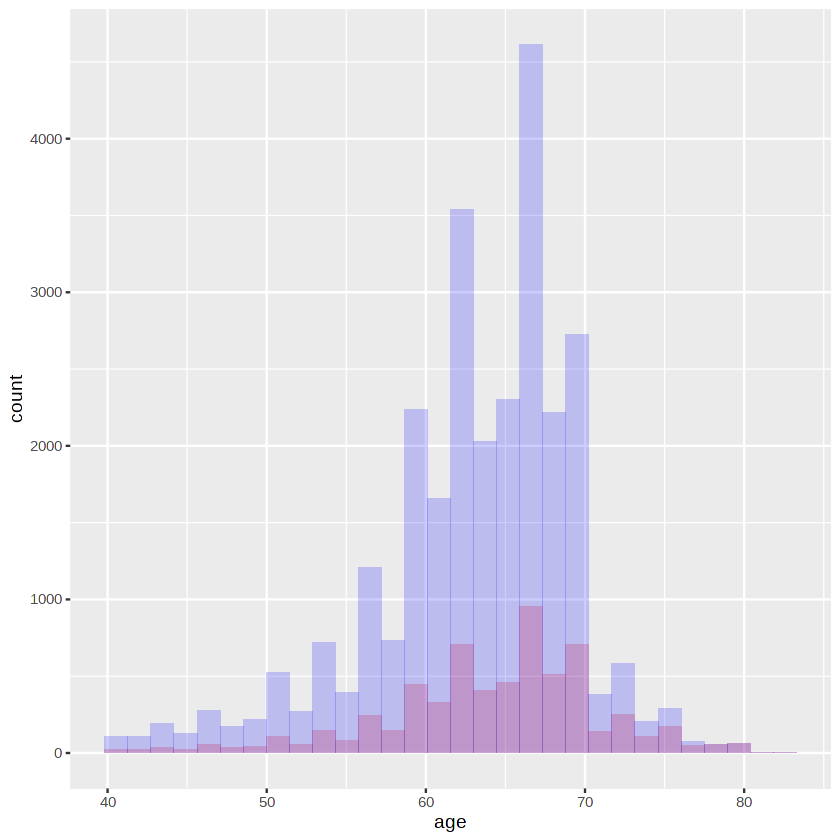

In [37]:
ggplot(f3393_match,aes(x=age)) +
    geom_histogram(data=subset(f3393_match,f3393 == '1'),fill = "red", alpha = 0.2) +
    geom_histogram(data=subset(f3393_match,f3393 == '0'),fill = "blue", alpha = 0.2) +
    theme_classic ()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



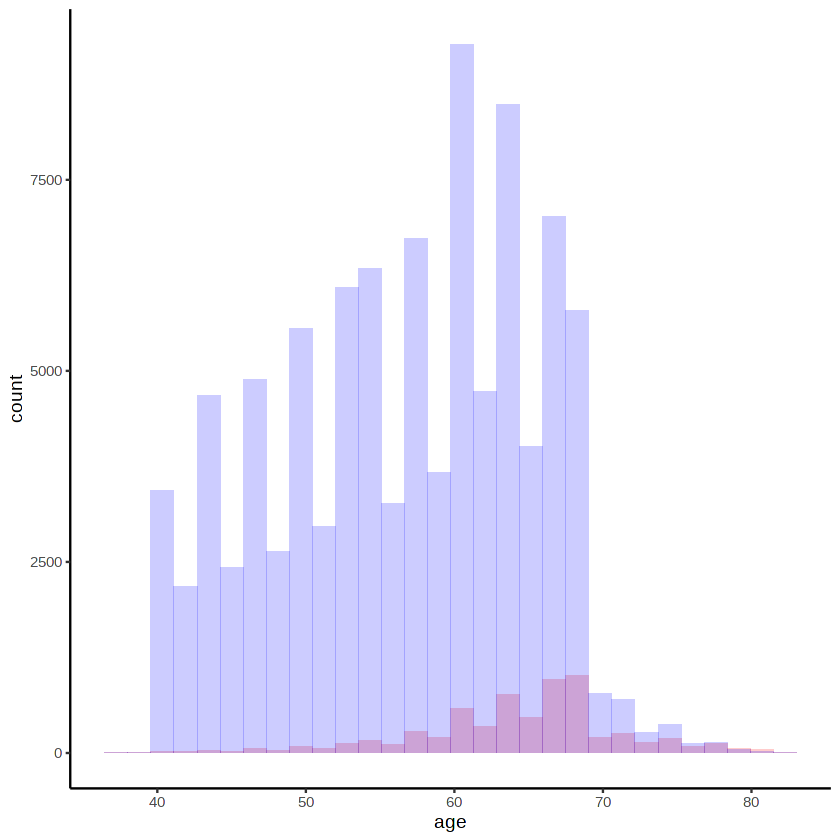

In [35]:
ggplot(raw_f3393,aes(x=age)) + 
    geom_histogram(data=subset(raw_f3393,f3393 == '1'),fill = "red", alpha = 0.2) +
    geom_histogram(data=subset(raw_f3393,f3393 == '0'),fill = "blue", alpha = 0.2) +
    theme_classic()

In [73]:
filter(raw_f3393, age <= 39)

FID,IID,sex,f3393,age,PC1,PC2
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1709450,1709450,0,0,38,-0.01066263,0.003443163
5016304,5016304,0,0,39,0.01802290,-0.029011409
